In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
# read the csv file into a pandas DataFrame
ross_df = pd.read_csv('resources/NewCleanTrain_merged.csv')
ross_df

,Store,DayOfWeek,Date,month,year,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,StHoliday_prox
0,1,5,7/31/2015,7,2015,5263,555,1,1,0,1,1270,9,2008,0,0
1,1,4,7/30/2015,7,2015,5020,546,1,1,0,1,1270,9,2008,0,0
2,1,3,7/29/2015,7,2015,4782,523,1,1,0,1,1270,9,2008,0,0
3,1,2,7/28/2015,7,2015,5011,560,1,1,0,1,1270,9,2008,0,0
4,1,1,7/27/2015,7,2015,6102,612,1,1,0,1,1270,9,2008,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,1115,6,1/5/2013,1,2013,4771,339,1,0,0,1,5350,9,2013,1,0
1017205,1115,5,1/4/2013,1,2013,4540,326,1,0,0,1,5350,9,2013,1,0
1017206,1115,4,1/3/2013,1,2013,4297,300,1,0,0,1,5350,9,2013,1,0
1017207,1115,3,1/2/2013,1,2013,3697,305,1,0,0,1,5350,9,2013,1,0


In [3]:
# assign the data to X and y
X = ross_df[["DayOfWeek", "month", "year", "Customers", "Open", "StHoliday_prox", "SchoolHoliday",
             "CompetitionDistance", "CompetitionOpenSinceMonth", "CompetitionOpenSinceYear", "Promo", "Promo2"]]
y = ross_df["Sales"].values.reshape(-1, 1)

print(X.shape, y.shape)

(1017209, 12) (1017209, 1)


In [4]:
# use train_test_split to create training and testing data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

### Fit our StandardScaler model to our training data with the fit/transform approach (isolating testing from training to avoid bias toward testing data), checking for a difference in the LGBMRegressor model

In [5]:
from sklearn.preprocessing import StandardScaler
X_scaler = StandardScaler().fit(X_train)
y_scaler = StandardScaler().fit(y_train)

In [6]:
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)
y_train_scaled = y_scaler.transform(y_train)
y_test_scaled = y_scaler.transform(y_test)

In [7]:
# pip install lightgbm

In [8]:
# using gradient boosted decision trees to predict 'Sales'
import lightgbm as lgb

model = lgb.LGBMRegressor(num_leaves=50, n_estimators=700, max_depth=-1, learning_rate=0.3,
                          subsample=1, colsample_bytree=0.8, reg_alpha=0.1, reg_lambda=1)

In [9]:
# fit the model to the training data
model.fit(X_train_scaled, y_train_scaled.ravel())

LGBMRegressor(colsample_bytree=0.8, learning_rate=0.3, n_estimators=700,
              num_leaves=50, reg_alpha=0.1, reg_lambda=1, subsample=1)

In [10]:
# plot the Residuals for the Training and Testing data
plt.scatter(model.predict(X_train_scaled), model.predict(X_train_scaled) - y_train_scaled, c="blue", label="Training Data")
plt.scatter(model.predict(X_test_scaled), model.predict(X_test_scaled) - y_test_scaled, c="orange", label="Testing Data")
plt.legend()
plt.hlines(y=0, xmin=y_test_scaled.min(), xmax=y_test_scaled.max())
plt.title("Residual Plot")
plt.show()

MemoryError: Unable to allocate 4.23 TiB for an array with shape (762906, 762906) and data type float64

In [11]:
# use our model to make predictions
y_pred = model.predict(X_test_scaled)

In [12]:
# convert arrays to ordinary lists with the same items
y_predl = y_pred.tolist()
y_testl = y_test_scaled.tolist()

In [13]:
pred_df = pd.DataFrame({"Predictions": y_predl, "Actual": y_testl})

# clean up [] around column elements
pred_df["Actual"] = pred_df["Actual"].str[0]

pred_df.head()

,Predictions,Actual
0,0.807471,0.664815
1,-0.942492,-0.929975
2,-0.108560,-0.103893
3,-0.401827,-0.483963
4,0.186151,-0.044442


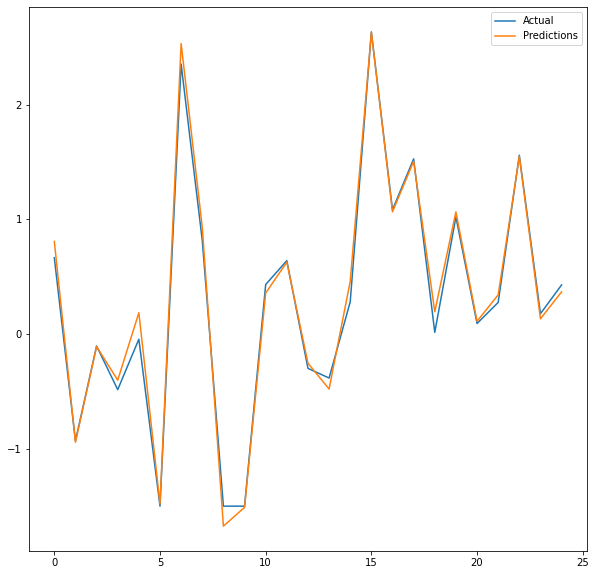

In [14]:
# plot the first 25 predictions vs actual sales
plt.figure(figsize=(10,10))
pred_df["Actual"][:25,].plot.line()
pred_df["Predictions"][:25,].plot.line()
plt.legend()
plt.show()

### Quantifying the Model:
#### A "good" MSE score will be close to zero, while a "good" R2 Score will be close to 1

In [15]:
# use X_test_scaled, y_test_scaled, and model.predict(X_test_scaled) to calculate MSE and R2(default scoring)
from sklearn.metrics import mean_squared_error

MSE = mean_squared_error(y_test_scaled, y_pred)
r2 = model.score(X_test_scaled, y_test_scaled)

print(f"Mean Squared Error (MSE): {MSE}")
print(f"R-squared (R2): {r2}")

Mean Squared Error (MSE): 0.014863351196078269
R-squared (R2): 0.9850747865196328
